# Forecasts with Time Delay Embeddings

First we generate some training data for the process, we want to forecast. 

In this first example, we generate data from a Lorenz system and only take the first / x dimension as training data. 

In the exercise you will apply this to temperature data.

In [1]:
import Pkg 
Pkg.activate(".");

using DynamicalSystems, Plots, NearestNeighbors

  Activating project at `~/Nextcloud/TUM-Dynamics-Lecture/lectures/lecture-6`


First, we generate the Lorenz data and plot it 

In [2]:
ds = Systems.lorenz();
tr = trajectory(ds, 500, Ttr=10.);
data = tr[:,1];

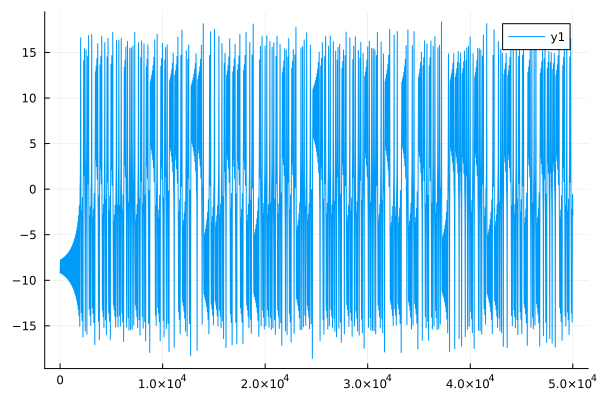

In [3]:
plot(data)

Then, we perform a time delay embedding.

In [4]:
D, τ, E = DelayEmbeddings.optimal_traditional_de(data)

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


(3-dimensional Dataset{Float64} with 49969 points, 16, [7.933180236801986e-5, 0.14113100106937895, 0.9156510440040191, 0.941719235614005, 0.9587382153356038, 0.9700903906082442, 0.9759922421839523, 0.990727021819594, 0.9932579390759411, 0.992053711024502])

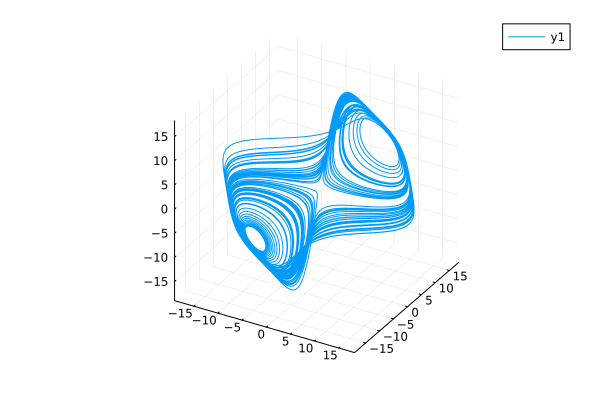

In [6]:
plot(D[1000:9000,1],D[1000:9000,2],D[1000:9000,3])

# Time Series Prediction with Time Delay Embeddings 

We can use the time delay embedding to make forecasts of time series. 

The basic idea is the following: a point in the high-dimensional (fully embedded / unfolded) phase space will evolve similar to its neighbours in phase space. 

We can set up a simple version of a model using this idea as follows: 

* We find locally the $N_N$ neighbours of a point in phase space $\vec{v}^{(r)}(n)$, $r=1,2,..,N_N$
* Our ansatz is a local linear model that predicts the next point: $\vec{v}(r;n+1) = \mathbf{A}_n + \mathbf{B}_n\cdot\vec{v}^{(r)}(n)$
* The coefficients are determined by a least square fit at every point in the dataset that minimizes $$\sum_{r=0}^{N_N} \left|\vec{v}(r;n+1) - \mathbf{A}_n - \mathbf{B}_n\cdot\vec{v}^{(r)}(n)\right|^2$$
* We can do this minimization with a linear regression (`\` operator in Julia)
* If we then want to forecast one step ahead from a new point $\vec{z}(k)$, we look up its neareast neigbour $\vec{v}(NN)$ and predict its evolution with $$\vec{z}(k+1) = \mathbf{A}_{NN} + \mathbf{B}_NN\cdot \vec{z}(k)$$
* For longer predictions, we apply this procedure recursively

In [7]:
struct LocalTDEPrediction{T,S,U}
    A::T # regression coefficients 
    B::T # regression coefficients 
    N_N::S # amount of neighbours 
    tree::U # neighbourhood tree
end 

"""
    LocalTDEPrediction(data, N_N::Integer)

Sets up a local linear prediction model, based on a time delay embedding `data`. 
The prediction is based on the dynamics a local model of `N_N` neighbours in phase
space
"""
function LocalTDEPrediction(data, N_N::Integer)
    neighbour_tree = KDTree(data[1:end-1,:]);
    N_d = size(data, 2)
        
    A = zeros(size(data,1) -1, N_d)
    B = zeros(size(data,1) -1, N_d) 
    
    for i_point = 1:(size(data,1) -1)
        
        inds, dists = knn(neighbour_tree, D[i_point,:], N_N) # returns the N_N neighbours of i_point

        for i=:1:N_d 
            coeffs = hcat(ones(N_N), D[inds,i]) \ D[inds.+1,i] # linear regression, seperately for each dimension 
            # we could improve it with a proper MLR
    
            A[i_point, i] = coeffs[1]
            B[i_point, i] = coeffs[2]
        end
    end
    LocalTDEPrediction(A, B, N_N, neighbour_tree)
end 
     

LocalTDEPrediction

In [8]:
"""
    predict(pred::LocalTDEPrediction, ic::AbstractVector{T})

Predict the system one step ahead from state `ic`. 
"""
function predict(pred::LocalTDEPrediction, ic::AbstractVector{T}) where T
    inds, dists = knn(pred.tree, ic, 1) # first the closest point 
    ind = inds[1]
    
    return pred.A[ind,:] .+ pred.B[ind,:] .* ic
end 

"""
    predict(pred::LocalTDEPrediction, ic::AbstractVector{T}, N::Integer)

Recursively uses a one step ahead prediction to predict the system for `N` steps. 
"""
function predict(pred::LocalTDEPrediction, ic::AbstractVector{T}, N::Integer) where T
    
    result = zeros(T, length(ic), N+1)
    result[:,1] = ic
    
    for i=2:N+1 
        result[:,i] = predict(pred, result[:,i-1])
    end 
    
    return result
end 

predict

We split the data into a training and validation set and setup the prediction model

In [9]:
N_train = Int(floor(0.8*size(D,1)))

D_train = D[1:N_train,:]
D_valid = D[N_train+1:end,:]

pred = LocalTDEPrediction(D_train, 10)

LocalTDEPrediction{Matrix{Float64}, Int64, KDTree{SVector{3, Float64}, Euclidean, Float64}}([-0.6149550500175482 0.44926801411095274 -0.47603396063296055; -0.7229373637618188 0.51918869151831 -0.6259022386573596; … ; 0.15005607687695105 -2.1338798996675035 -0.4966900134189281; 0.18965937722087034 -2.445254431468754 -0.4559381084784693], [0.93758490874099 1.0437027957031664 0.9338152325254894; 0.9252315371734975 1.0513365362292761 0.9153485633697283; … ; 1.0675278910677068 1.0936765119154523 0.9804494099266433; 1.062036576407188 1.10863014624253 0.9836191473202196], 10, KDTree{SVector{3, Float64}, Euclidean, Float64}
  Number of points: 39974
  Dimensions: 3
  Metric: Euclidean(0.0)
  Reordered: true)

Then, we apply the prediction.

In [10]:
N_predict = 200
prediction_result = predict(pred, D_valid[1,:], N_predict);
truth = D_valid[1:N_predict+1,:];

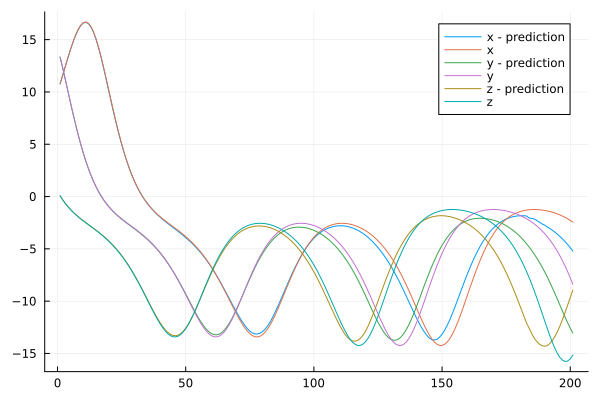

In [11]:
plot(prediction_result[1,:], label="x - prediction")
plot!(truth[:,1], label="x")

plot!(prediction_result[2,:], label="y - prediction")
plot!(truth[:,2], label="y")

plot!(prediction_result[3,:], label="z - prediction")
plot!(truth[:,3], label="z")

We could improve this method with more sophisticated local models than just the linear regression. But already like this, we get decent results for the Lorenz system. Remember, due to the chaotic nature of the Lorenz system even the smalles deviations will grow exponentially, so that forecast lengths will always be limited 